This Notebook aims to combine all necessary steps for each model of the shrinkage methods.

In [2]:
# first import the libraries
import pandas as pd
import numpy as np
from darts import TimeSeries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from darts.models import LinearRegressionModel, RegressionModel, RandomForest, RegressionEnsembleModel
from sklearn import cross_decomposition
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from darts.metrics import mape, r2_score, mase, mse
import sklearn
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


import warnings

In [3]:
from scipy.linalg import LinAlgWarning

In [4]:
# Filter out the FutureWarning message
warnings.filterwarnings("ignore", category=(FutureWarning))
warnings.filterwarnings("ignore", category=(UserWarning))
# get rid of the LinAlgWarning message
#from numpy.linalg import LinAlgWarning
#warnings.filterwarnings('ignore', category=LinAlgWarning)

In [5]:
# load the data, use Darts TimeSeries
ts = TimeSeries.from_csv('data/price_data_filtered.csv', parse_dates=True, index_col=0)

In [6]:
# compute monthly returns using pandas pct_change
returns = ts.pd_dataframe().pct_change().dropna()

Stored 'cum_returns' (DataFrame)


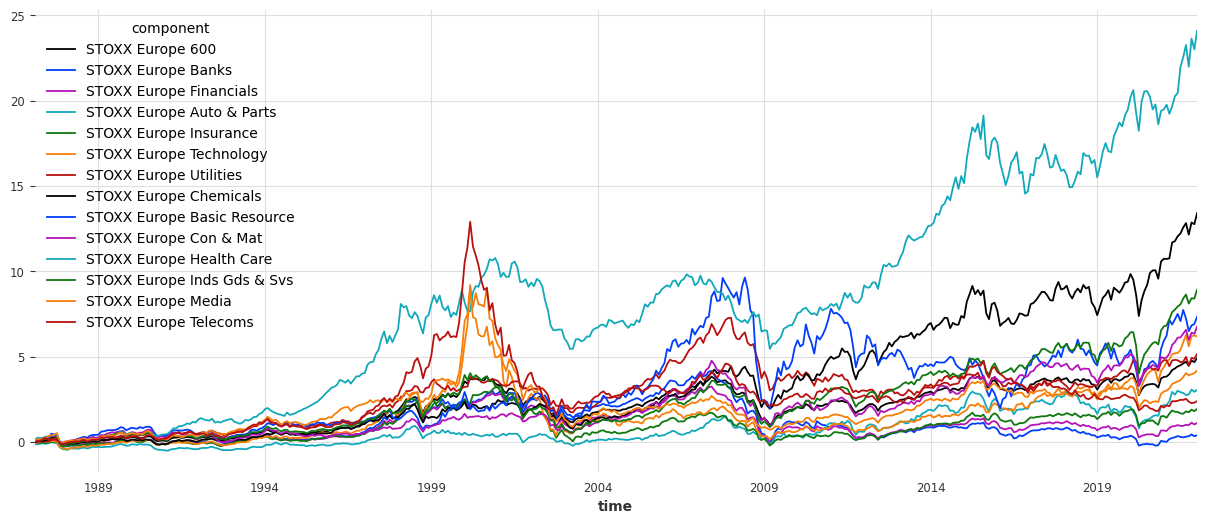

In [7]:
#from io import BytesIO
# compute the cumulative monthly returns
cum_returns = (1 + returns).cumprod() - 1

cum_returns_portfolio = cum_returns
# store the cum_returns to use it in another notebook
%store cum_returns

# plot the cumulative returns
fig, ax = plt.subplots(figsize=(15, 6))
cum_returns.plot(ax=ax);

In [8]:
# to use the Darts models, we need to convert the data to a Darts TimeSeries
cum_returns = TimeSeries.from_dataframe(df = cum_returns,time_col= 0, fill_missing_dates=True)

In [9]:
# split the data into training and test set, use 80% for training
train, test = cum_returns.split_after(0.8)

## Benchmark Portfolios

Our main benchmark is the STOXX Europe 600 Index. Furthermore, we expand the benchmarks by computing the equal weighted portfolio and portfolio based on historical averages.

### Equal Weighted Portfolio

In [10]:
# create a list of the column names
col_list = list(cum_returns.columns)[1:]

In [11]:
# create weights
weights_ew = 1/len(col_list)

In [12]:
# print single weight and the sum of all weights
print('The weight for each stock is: ' + str(weights_ew))
print('The sum of all weights is: ' + str(weights_ew * 13))

The weight for each stock is: 0.07692307692307693
The sum of all weights is: 1.0


In [13]:
# create a new column in cum_returns for the equal weighted portfolio
cum_returns_portfolio['equal_weighted'] = cum_returns_portfolio[col_list].mul(weights_ew).sum(axis=1)

In [14]:
# create a new variable called portfolio_returns with same structure as cum_returns
portfolio_returns = cum_returns_portfolio.copy()
# delete all columns except for the equal_weighted column
portfolio_returns.drop(cum_returns_portfolio.columns.difference(['equal_weighted']), 1, inplace=True)
portfolio_returns.tail()

component,equal_weighted
time,
2021-09-01,6.334322
2021-10-01,5.926514
2021-11-01,6.322933
2021-12-01,6.237121
2022-01-01,6.544394


In [15]:
# delete equal weighted column from cum_returns
cum_returns_portfolio.drop('equal_weighted', axis=1, inplace=True)

### Portfolio based on Historical Average

In [16]:
# Calculate average daily returns for each stock and exlude the first column
avg_returns = cum_returns_portfolio.mean()[1:]

# Calculate weights based on average daily returns
weights_ha = avg_returns / avg_returns.sum()

# Calculate portfolio returns
ha_returns = (cum_returns_portfolio * weights_ha).sum(axis=1)

# Add portfolio_returns as a new column in cum_returns
portfolio_returns['historical_average'] = ha_returns

# show the last 5 rows of portfolio_returns of historical average portfolio
portfolio_returns.tail()

component,equal_weighted,historical_average
time,,
2021-09-01,6.334322,10.565259
2021-10-01,5.926514,9.912039
2021-11-01,6.322933,10.583310
2021-12-01,6.237121,10.402550
2022-01-01,6.544394,10.913366


In [17]:
# print single weight and the sum of all weights for historical average portfolio
print('The weight for each stock is: ' + str(weights_ha))
print('The sum of all weights is: ' + str(weights_ha.sum()))

The weight for each stock is: component
STOXX Europe Banks             0.033024
STOXX Europe Financials        0.030685
STOXX Europe Auto & Parts      0.021829
STOXX Europe Insurance         0.027747
STOXX Europe Technology        0.050778
STOXX Europe Utilities         0.085845
STOXX Europe Chemicals         0.108597
STOXX Europe Basic Resource    0.099537
STOXX Europe Con & Mat         0.061754
STOXX Europe Health Care       0.258600
STOXX Europe Inds Gds & Svs    0.076979
STOXX Europe Media             0.063096
STOXX Europe Telecoms          0.081530
dtype: float64
The sum of all weights is: 1.0


### Plotting benchmarks

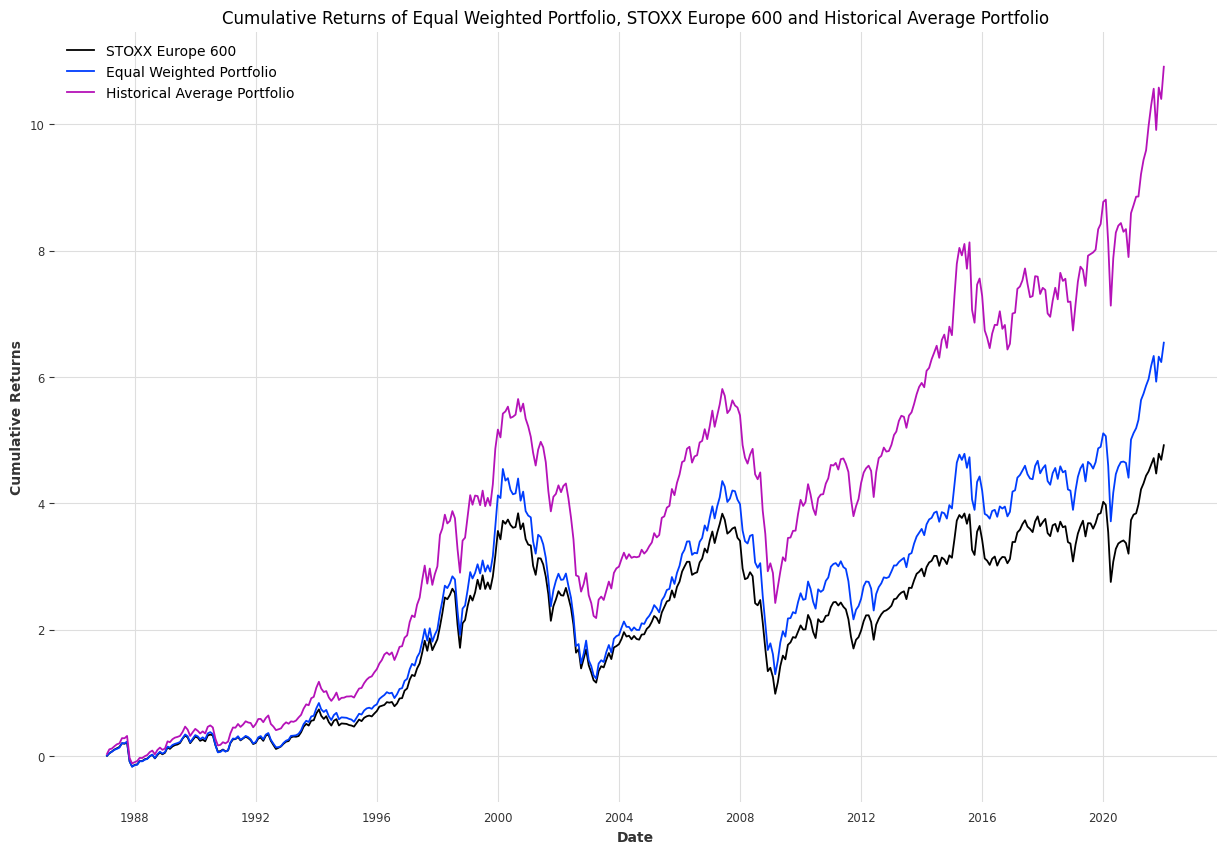

In [18]:
# plot the cumulative returns of the equal weighted portfolio, the STOXX Europe 600 and the historical average portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.legend(loc='upper left')
plt.title('Cumulative Returns of Equal Weighted Portfolio, STOXX Europe 600 and Historical Average Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show();

In [19]:
# show only the last value of equal weighted portfolio, STOXX Europe 600 and historical average portfolio
print('The last value of the STOXX Europe 600 is: ' + str(round(cum_returns_portfolio.iloc[-1,0], 2)) + '%')
print('The last value of the equal weighted portfolio is: ' + str(round(portfolio_returns.iloc[-1,0], 2)) + '%') 
print('The last value of the historical average portfolio is: ' + str(round(portfolio_returns.iloc[-1,1], 2)) + '%')

The last value of the STOXX Europe 600 is: 4.92%
The last value of the equal weighted portfolio is: 6.54%
The last value of the historical average portfolio is: 10.91%


## Shrinkage Methods

### Linear Regression

In [19]:
# the only hyperparameter for the linear regression model is the number of lags
hyperparameter_linear = {
    "lags": list(range(1, 336))
}

In [20]:
# the gridsearch function returns the best model with regard to the metric, which does not necessarily have to be the best model in terms of performance

tuning_linear = LinearRegressionModel.gridsearch(
    parameters= hyperparameter_linear,
    series= train, # The target series used as input and target for training.
    val_series= test,
    start= 0.0, # represents the starting point in the time index of series from which predictions will be made to evaluate the model
    #metric= , # function that takes actual and prediction, and returns a float error value
    n_jobs= -1, # setting the parameter to -1 means using all the available cores
    verbose= True # whether to print progress
)

  0%|          | 0/335 [00:00<?, ?it/s]

In [21]:
best_model, best_params = tuning_linear[0], tuning_linear[1]
best_model.model_params

OrderedDict([('lags', 314),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('likelihood', None),
             ('quantiles', None),
             ('random_state', None),
             ('multi_models', True),
             ('use_static_covariates', True)])

In [36]:
# I have tested the model with different lags, which have shown the best results for mape and mse
linear_model_1 = LinearRegressionModel(lags=1, output_chunk_length=1)
linear_model_1.fit(train)
linear_forecast_1 = linear_model_1.predict(len(test))

# linear regression model with 316 lags of STOXX Europe 600
linear_model_316 = LinearRegressionModel(lags=316, output_chunk_length=1)
linear_model_316.fit(train)
linear_forecast_316 = linear_model_316.predict(len(test))

# linear regression model with 317 lags of STOXX Europe 600
linear_model_317 = LinearRegressionModel(lags=317, output_chunk_length=1)
linear_model_317.fit(train)
linear_forecast_317 = linear_model_317.predict(len(test))

# linear regression model with 335 lags of STOXX Europe 600
linear_model_335 = LinearRegressionModel(lags=335, output_chunk_length=1)
linear_model_335.fit(train) # ['STOXX Europe 600']
linear_forecast_335 = linear_model_335.predict(len(test))

%store linear_forecast_1
%store linear_forecast_316
%store linear_forecast_317
%store linear_forecast_335


Stored 'linear_forecast_1' (TimeSeries)
Stored 'linear_forecast_316' (TimeSeries)
Stored 'linear_forecast_317' (TimeSeries)
Stored 'linear_forecast_335' (TimeSeries)


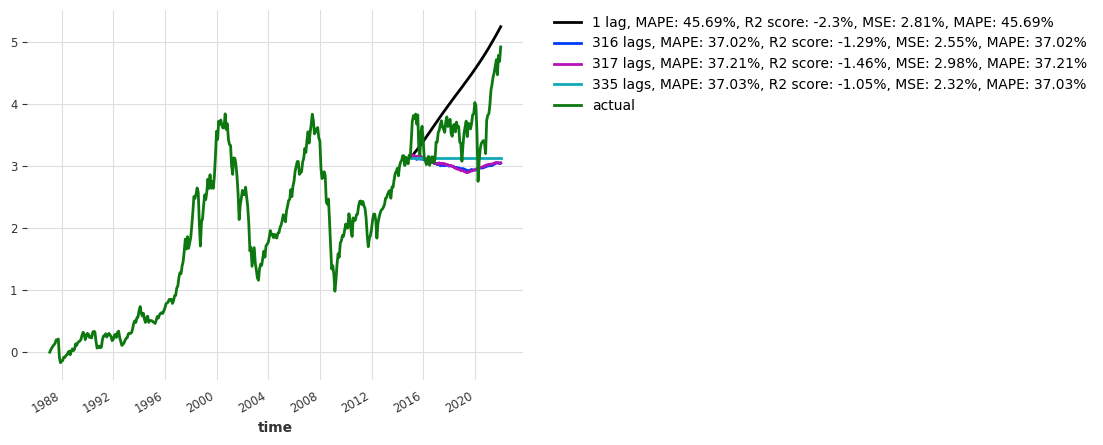

In [37]:
# plot linear forecast with 1, 316 and 335 lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
linear_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, linear_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, linear_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, linear_forecast_1), 2)) + '%, MAPE: ' + str(round(mape(test, linear_forecast_1), 2)) + '%')
linear_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, linear_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, linear_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, linear_forecast_316), 2)) + '%, MAPE: ' + str(round(mape(test, linear_forecast_316), 2)) + '%')
linear_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, linear_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, linear_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, linear_forecast_317), 2)) + '%, MAPE: ' + str(round(mape(test, linear_forecast_317), 2)) + '%')
linear_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, linear_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, linear_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, linear_forecast_335), 2)) + '%, MAPE: ' + str(round(mape(test, linear_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')
# show the legend outside the plot 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [38]:
# we would assume that one of the model with the most lags would perform best, but this is not the case
# backtesting shows the following results

# first linear regression model with 1 lag
hf1_linear_regression = linear_model_1.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.6,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

# second linear regression model with 316 lags
hf2_linear_regression = linear_model_316.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.6,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

# third linear regression model with 317 lags
hf3_linear_regression = linear_model_317.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.6,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

# fourth linear regression model with 335 lags
hf4_linear_regression = linear_model_335.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.6,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

  0%|          | 0/169 [00:00<?, ?it/s]

`start` value `0.6` corresponding to timestamp `2008-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-08-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/102 [00:00<?, ?it/s]

`start` value `0.6` corresponding to timestamp `2008-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-09-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/101 [00:00<?, ?it/s]

`start` value `0.6` corresponding to timestamp `2008-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2015-03-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/83 [00:00<?, ?it/s]

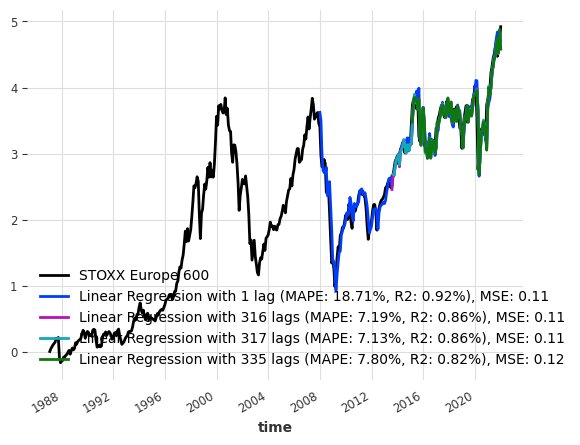

In [39]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_linear_regression['STOXX Europe 600'].plot(label='Linear Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_linear_regression, cum_returns), r2_score(hf1_linear_regression, cum_returns), mse(hf1_linear_regression, cum_returns)))
hf2_linear_regression['STOXX Europe 600'].plot(label='Linear Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_linear_regression, cum_returns), r2_score(hf2_linear_regression, cum_returns), mse(hf2_linear_regression, cum_returns)))
hf3_linear_regression['STOXX Europe 600'].plot(label='Linear Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf3_linear_regression, cum_returns), r2_score(hf3_linear_regression, cum_returns), mse(hf3_linear_regression, cum_returns)))
hf4_linear_regression['STOXX Europe 600'].plot(label='Linear Regression with 335 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf4_linear_regression, cum_returns), r2_score(hf4_linear_regression, cum_returns), mse(hf4_linear_regression, cum_returns)))

This shows that the model with 1 lags would have performed best, since it has the highest R2 and the lowest MSE. We will also check this when we build our portfolios using the different lag settings or forecasts, respectively.

#### Portfolio

In [40]:
# change the type of the linear_forecast to a pandas dataframe
linear_forecast_1 = linear_forecast_1.pd_dataframe()
linear_forecast_316 = linear_forecast_316.pd_dataframe()

In [27]:
# show there mean values
#print('Mean of linear_forecast_1: ' + str(linear_forecast_1.mean()))
#print('Mean of linear_forecast_316: ' + str(linear_forecast_316.mean()))
#print('Mean of linear_forecast_317: ' + str(linear_forecast_317.mean()))

In [41]:
# use the pyportfolioopt library to compute the optimal portfolio 

# perform mean-variance optimization with the linear regression forecast
mu_linear_regression_1 = expected_returns.mean_historical_return(linear_forecast_1)
S_linear_regression_1 = risk_models.sample_cov(linear_forecast_1)

mu_linear_regression_316 = expected_returns.mean_historical_return(linear_forecast_316)
S_linear_regression_316 = risk_models.sample_cov(linear_forecast_316)

In [42]:
# optimize for maximal sharpe ratio
# sharpe ratio is about to find the maximum return for a given risk

ef_linear_regression_1 = EfficientFrontier(mu_linear_regression_1, S_linear_regression_1)
weights_lr_1 = ef_linear_regression_1.max_sharpe()

ef_linear_regression_316 = EfficientFrontier(mu_linear_regression_316, S_linear_regression_316)
weights_lr_316 = ef_linear_regression_316.max_sharpe()

In [30]:
# print the weights in a table and round them to 3 decimals and add their sum
#print('Weights for linear regression with 1 lag: ' + str(np.round(pd.Series(weights_lr_1), 3)))
#print('Weights for linear regression with 316 lags: ' + str(np.round(pd.Series(weights_lr_316), 3)))

In [43]:
lr_returns_1 = (cum_returns_portfolio * weights_lr_1).sum(axis=1)
lr_returns_316 = (cum_returns_portfolio * weights_lr_316).sum(axis=1)

# Add portfolio_returns as a new column in cum_returns
portfolio_returns['linear_regression_1'] = lr_returns_1
portfolio_returns['linear_regression_316'] = lr_returns_316

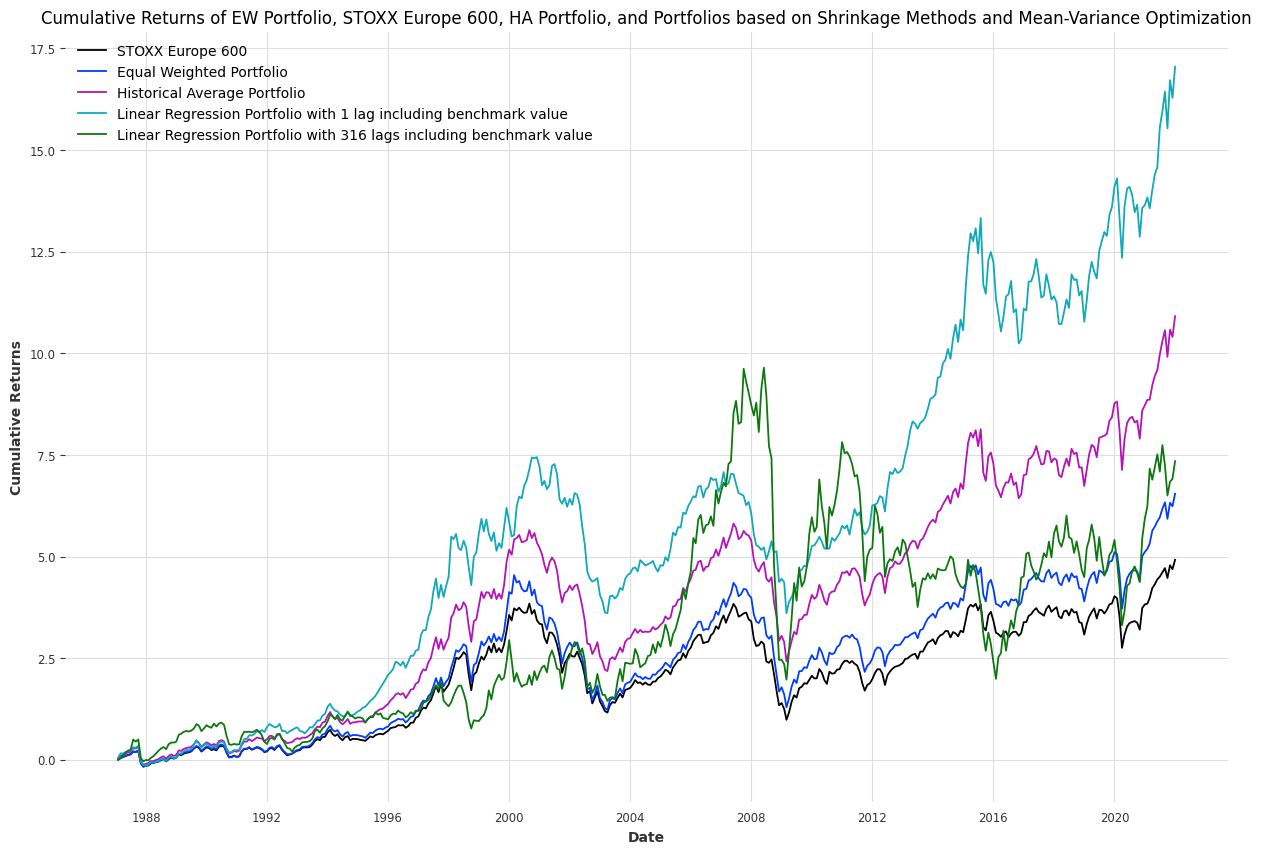

In [44]:
# plot the cumulative returns of the benchmarks and the portfolio constructed with the linear regression forecast
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['linear_regression_1'], label='Linear Regression Portfolio with 1 lag including benchmark value')
plt.plot(portfolio_returns['linear_regression_316'], label='Linear Regression Portfolio with 316 lags including benchmark value')
plt.legend(loc='upper left')
plt.title('Cumulative Returns of EW Portfolio, STOXX Europe 600, HA Portfolio, and Portfolios based on Shrinkage Methods and Mean-Variance Optimization')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show();

In [33]:
#show the last value of each portfolio in percent and round two 2 decimals
print('Last value of the STOXX Europe 600: ' + str(round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2)) + '%')
print('Last value of the equal weighted portfolio: ' + str(round(portfolio_returns['equal_weighted'].iloc[-1], 2)) + '%')
print('Last value of the historical average portfolio: ' + str(round(portfolio_returns['historical_average'].iloc[-1], 2)) + '%')
print('Last value of the linear regression portfolio with 1 lag: ' + str(round(portfolio_returns['linear_regression_1'].iloc[-1], 2)) + '%')
print('Last value of the linear regression portfolio with 316 lags: ' + str(round(portfolio_returns['linear_regression_316'].iloc[-1], 2)) + '%')

Last value of the STOXX Europe 600: 4.92%
Last value of the equal weighted portfolio: 6.54%
Last value of the historical average portfolio: 10.91%
Last value of the linear regression portfolio with 1 lag: 17.05%
Last value of the linear regression portfolio with 316 lags: 7.35%


This shows once more, that the forecasts with 1 lag perform best.

### Ridge Regression

In [34]:
hyperparameter_ridge = {
    "lags": list(range(1,336,2)),
    'model': [
        sklearn.linear_model.Ridge(alpha=a) for a in np.arange(0, 1.1, 0.1)
    ]
}

In [35]:
ridge_regression_tune = RegressionModel(
    lags= hyperparameter_ridge['lags'][0],
    model=sklearn.linear_model.Ridge(0)
)

In [36]:
tuning_ridge = ridge_regression_tune.gridsearch(
    parameters= hyperparameter_ridge,
    series= train,
    val_series= test,
    start= 0.1,
    #metric= mse,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/1848 [00:00<?, ?it/s]

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=9.26853e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.08156e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3

In [37]:
best_model, best_params = tuning_ridge[0], tuning_ridge[1]
best_model.model_params

OrderedDict([('lags', 317),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model', Ridge(alpha=0.0)),
             ('multi_models', True),
             ('use_static_covariates', True)])

In [45]:
# I have tested the model with different lags, which have shown the best results for mape and mse
# ridge regression model with 1 lag of STOXX Europe 600
ridge_model_1 = RegressionModel(lags=1, model=sklearn.linear_model.Ridge(alpha=1))
ridge_model_1.fit(train)
ridge_forecast_1 = ridge_model_1.predict(len(test))

# ridge regression model with 316 lags of STOXX Europe 600
ridge_model_316 =RegressionModel(lags=316, model=sklearn.linear_model.Ridge(alpha=1))
ridge_model_316.fit(train)
ridge_forecast_316 = ridge_model_316.predict(len(test))

# ridge regression model with 317 lags of STOXX Europe 600
ridge_model_317 = RegressionModel(lags=317, model=sklearn.linear_model.Ridge(alpha=1))
ridge_model_317.fit(train)
ridge_forecast_317 = ridge_model_317.predict(len(test))

# ridge regression model with 335 lags of STOXX Europe 600
ridge_model_335 = RegressionModel(lags=335, model=sklearn.linear_model.Ridge(alpha=1))
ridge_model_335.fit(train)
ridge_forecast_335 = ridge_model_335.predict(len(test))

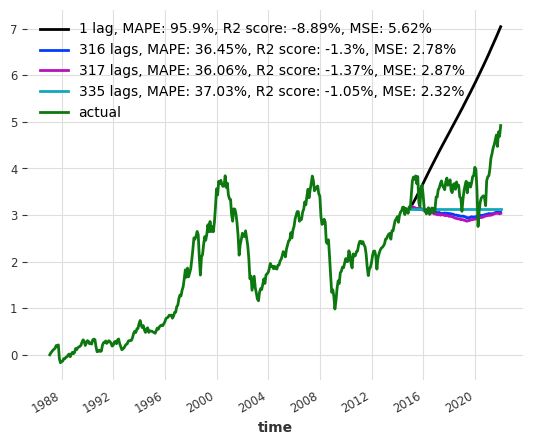

In [46]:
# plot the ridge forecast with 1, 316, 317 and 335 lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
ridge_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, ridge_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, ridge_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, ridge_forecast_1), 2)) + '%')
ridge_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, ridge_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, ridge_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, ridge_forecast_316), 2)) + '%')
ridge_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, ridge_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, ridge_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, ridge_forecast_317), 2)) + '%')
ridge_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, ridge_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, ridge_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, ridge_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [47]:
# first ridge regression model with 1 lag
hf1_ridge_regression = ridge_model_1.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.7,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

# second ridge regression model with 316 lags
hf2_ridge_regression = ridge_model_316.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.6,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

# third ridge regression model with 317 lags
hf3_ridge_regression = ridge_model_317.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.6,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

# fourth ridge regression model with 335 lags
hf4_ridge_regression = ridge_model_335.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.6,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

  0%|          | 0/127 [00:00<?, ?it/s]

`start` value `0.6` corresponding to timestamp `2008-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-08-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/102 [00:00<?, ?it/s]

`start` value `0.6` corresponding to timestamp `2008-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-09-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/101 [00:00<?, ?it/s]

`start` value `0.6` corresponding to timestamp `2008-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2015-03-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/83 [00:00<?, ?it/s]

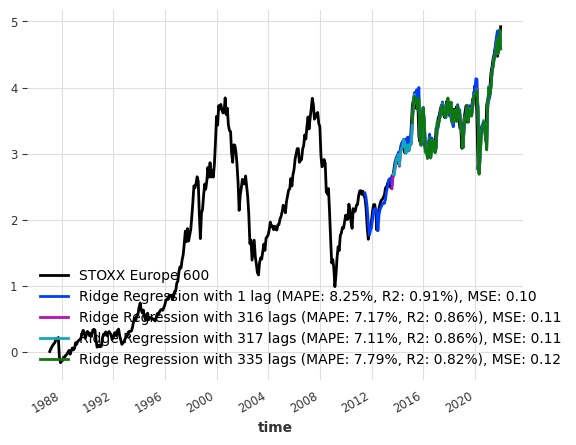

In [48]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_ridge_regression['STOXX Europe 600'].plot(label='Ridge Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_ridge_regression, cum_returns), r2_score(hf1_ridge_regression, cum_returns), mse(hf1_ridge_regression, cum_returns)))
hf2_ridge_regression['STOXX Europe 600'].plot(label='Ridge Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_ridge_regression, cum_returns), r2_score(hf2_ridge_regression, cum_returns), mse(hf2_ridge_regression, cum_returns)))
hf3_ridge_regression['STOXX Europe 600'].plot(label='Ridge Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf3_ridge_regression, cum_returns), r2_score(hf3_ridge_regression, cum_returns), mse(hf3_ridge_regression, cum_returns)))
hf4_ridge_regression['STOXX Europe 600'].plot(label='Ridge Regression with 335 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf4_ridge_regression, cum_returns), r2_score(hf4_ridge_regression, cum_returns), mse(hf4_ridge_regression, cum_returns)))

#### Portfolio

In [49]:
ridge_forecast_1 = ridge_forecast_1.pd_dataframe()
ridge_forecast_316 = ridge_forecast_316.pd_dataframe()

In [50]:
# perform mean-variance optimization with the ridge regression forecast
mu_ridge_regression_1 = expected_returns.mean_historical_return(ridge_forecast_1)
S_ridge_regression_1 = risk_models.sample_cov(ridge_forecast_1)

mu_ridge_regression_316 = expected_returns.mean_historical_return(ridge_forecast_316)
S_ridge_regression_316 = risk_models.sample_cov(ridge_forecast_316)

In [51]:
# optimize for maximal Sharpe ratio
ef_ridge_regression_1 = EfficientFrontier(mu_ridge_regression_1, S_ridge_regression_1)
ef_ridge_regression_316 = EfficientFrontier(mu_ridge_regression_316, S_ridge_regression_316)

weights_rr_1 = ef_ridge_regression_1.max_sharpe()
weights_rr_316 = ef_ridge_regression_316.max_sharpe()

In [164]:
# print the weights in a table and round them to 2 decimal places
print('Weights for ridge regression with 1 lag: ' + str(np.round(pd.Series(weights_rr_1), 3)))
print('Weights for ridge regression with 316 lags: ' + str(np.round(pd.Series(weights_rr_316), 3)))

Weights for ridge regression with 1 lag: STOXX Europe 600               0.0
STOXX Europe Banks             0.0
STOXX Europe Financials        0.0
STOXX Europe Auto & Parts      0.0
STOXX Europe Insurance         0.0
STOXX Europe Technology        0.0
STOXX Europe Utilities         0.0
STOXX Europe Chemicals         0.0
STOXX Europe Basic Resource    0.0
STOXX Europe Con & Mat         0.0
STOXX Europe Health Care       1.0
STOXX Europe Inds Gds & Svs    0.0
STOXX Europe Media             0.0
STOXX Europe Telecoms          0.0
dtype: float64
Weights for ridge regression with 316 lags: STOXX Europe 600              -0.0
STOXX Europe Banks            -0.0
STOXX Europe Financials        0.0
STOXX Europe Auto & Parts      0.0
STOXX Europe Insurance         0.0
STOXX Europe Technology        0.0
STOXX Europe Utilities         0.0
STOXX Europe Chemicals        -0.0
STOXX Europe Basic Resource    1.0
STOXX Europe Con & Mat         0.0
STOXX Europe Health Care      -0.0
STOXX Europe Inds Gds & S

In [52]:
# calculate the returns of the ridge regression portfolio
rr_returns_1 = (cum_returns_portfolio * weights_rr_1).sum(axis=1)
rr_returns_316 = (cum_returns_portfolio * weights_rr_316).sum(axis=1)

portfolio_returns['ridge_regression_1'] = rr_returns_1
portfolio_returns['ridge_regression_316'] = rr_returns_316

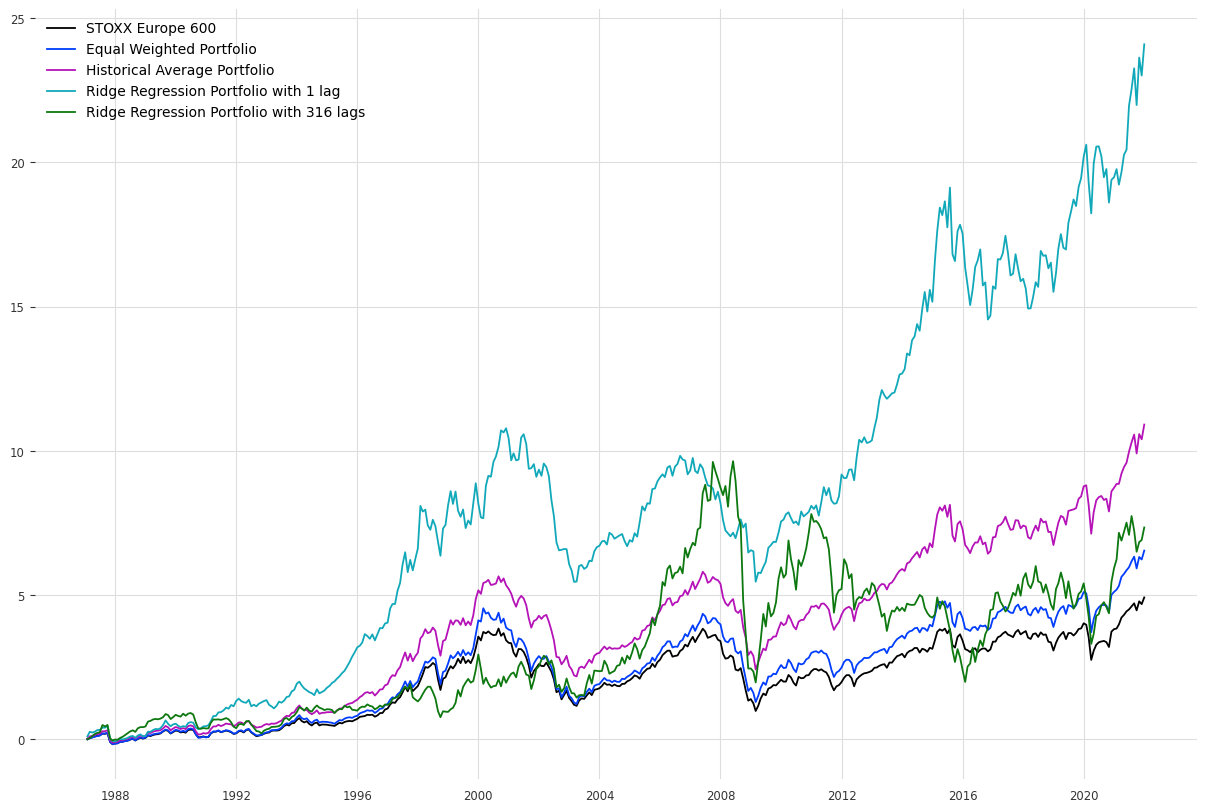

In [53]:
# plot the cumulative returns of the benchmark and the ridge regression portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['ridge_regression_1'], label='Ridge Regression Portfolio with 1 lag')
plt.plot(portfolio_returns['ridge_regression_316'], label='Ridge Regression Portfolio with 316 lags')
plt.legend()
plt.show();

In [ ]:
# show the last value of each portfolio and round it to 2 decimal places
print('Last value of the STOXX Europe 600: ' + str(np.round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2)) + '%')
print('Last value of the equal weighted portfolio: ' + str(np.round(portfolio_returns['equal_weighted'].iloc[-1], 2)) + '%')
print('Last value of the historical average portfolio: ' + str(np.round(portfolio_returns['historical_average'].iloc[-1], 2)) + '%')
print('Last value of the ridge regression portfolio with 1 lag: ' + str(np.round(portfolio_returns['ridge_regression_1'].iloc[-1], 12)) + '%')
print('Last value of the ridge regression portfolio with 316 lags: ' + str(np.round(portfolio_returns['ridge_regression_316'].iloc[-1], 5)) + '%')
# also for the linear regression portfolio
print('Last value of the linear regression portfolio: ' + str(np.round(portfolio_returns['linear_regression_1'].iloc[-1], 12)) + '%')
print('Last value of the linear regression portfolio: ' + str(np.round(portfolio_returns['linear_regression_316'].iloc[-1], 5)) + '%')


Last value of the STOXX Europe 600: 4.92%
Last value of the equal weighted portfolio: 6.54%
Last value of the historical average portfolio: 10.91%
Last value of the ridge regression portfolio with 1 lag: 17.04989306887%
Last value of the ridge regression portfolio with 316 lags: 7.34663%
Last value of the linear regression portfolio: 17.049893068824%
Last value of the linear regression portfolio: 7.34673%


### Lasso Regression

In [181]:
hyperparameter_lasso = {
    "lags": list(range(1,2)),
    'model': [
        sklearn.linear_model.Lasso(alpha=a) for a in np.arange(0, 1.1, 0.01)
    ]
}

In [182]:
lasso_regression_tune = RegressionModel(
    lags= hyperparameter_lasso['lags'][0],
    model=sklearn.linear_model.Lasso(0)
)

In [185]:
tuning_lasso = lasso_regression_tune.gridsearch(
    parameters= hyperparameter_lasso,
    series= train,
    val_series= test,
    start= 0.1,
    #metric= mape,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/110 [00:00<?, ?it/s]

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/darts/models/forecasting/regression_model.py:410: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(training_samples, training_labels, **kwargs)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.522e+00, tolerance: 4.405e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fit

In [186]:
best_model, best_params = tuning_lasso[0], tuning_lasso[1]
best_model.model_params

OrderedDict([('lags', 1),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model', Lasso(alpha=0.0)),
             ('multi_models', True),
             ('use_static_covariates', True)])

In [54]:
# I have tested the model with different lags, which have shown the best results for mape and mse
# lasso regression model with 1 lag of STOXX Europe 600
lasso_model_1 = RegressionModel(lags=1, model=sklearn.linear_model.Lasso(alpha=0))
lasso_model_1.fit(train)
lasso_forecast_1 = lasso_model_1.predict(len(test))

# lasso regression model with 316 lags of STOXX Europe 600
lasso_model_316 = RegressionModel(lags=316, model=sklearn.linear_model.Lasso(alpha=0))
lasso_model_316.fit(train)
lasso_forecast_316 = lasso_model_316.predict(len(test))

# lasso regression model with 317 lags of STOXX Europe 600
lasso_model_317 = RegressionModel(lags=317, model=sklearn.linear_model.Lasso(alpha=0))
lasso_model_317.fit(train)
lasso_forecast_317 = lasso_model_317.predict(len(test))

# lasso regression model with 335 lags of STOXX Europe 600
lasso_model_335 = RegressionModel(lags=335, model=sklearn.linear_model.Lasso(alpha=0))
lasso_model_335.fit(train)
lasso_forecast_335 = lasso_model_335.predict(len(test))

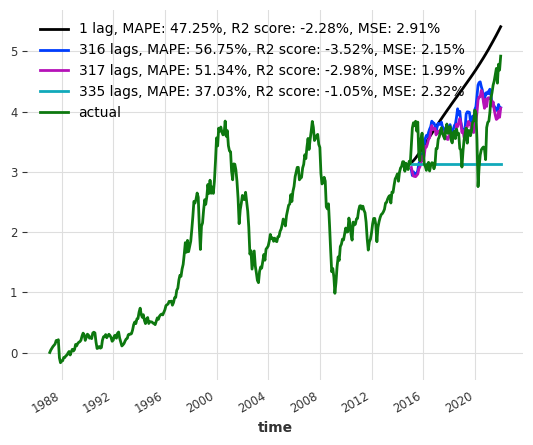

In [55]:
# plot the lasso forecast with 1, 316, 317 and 335 lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
lasso_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, lasso_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, lasso_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, lasso_forecast_1), 2)) + '%')
lasso_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, lasso_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, lasso_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, lasso_forecast_316), 2)) + '%')
lasso_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, lasso_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, lasso_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, lasso_forecast_317), 2)) + '%')
lasso_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, lasso_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, lasso_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, lasso_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [56]:
# first lasso regression model with 1 lag
hf1_lasso_regression = lasso_model_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# second lasso regression model with 316 lags
hf2_lasso_regression = lasso_model_316.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# third lasso regression model with 317 lags
hf3_lasso_regression = lasso_model_317.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# fourth lasso regression model with 335 lags
hf4_lasso_regression = lasso_model_335.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

  0%|          | 0/169 [00:00<?, ?it/s]

`start` value `0.6` corresponding to timestamp `2008-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-08-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/102 [00:00<?, ?it/s]

`start` value `0.6` corresponding to timestamp `2008-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-09-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/101 [00:00<?, ?it/s]

`start` value `0.6` corresponding to timestamp `2008-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2015-03-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/83 [00:00<?, ?it/s]

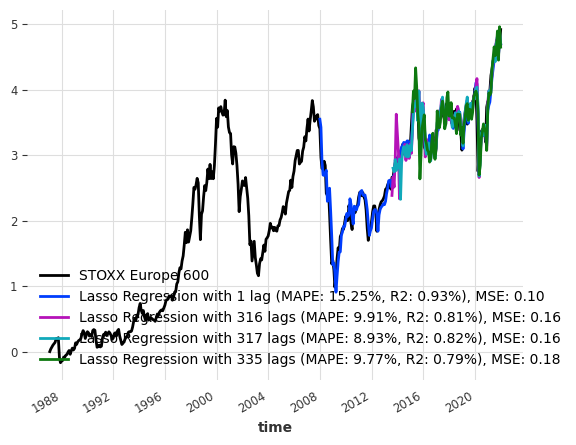

In [57]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_lasso_regression['STOXX Europe 600'].plot(label='Lasso Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_lasso_regression, cum_returns), r2_score(hf1_lasso_regression, cum_returns), mse(hf1_ridge_regression, cum_returns)))
hf2_lasso_regression['STOXX Europe 600'].plot(label='Lasso Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_lasso_regression, cum_returns), r2_score(hf2_lasso_regression, cum_returns), mse(hf2_lasso_regression, cum_returns)))
hf3_lasso_regression['STOXX Europe 600'].plot(label='Lasso Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf3_lasso_regression, cum_returns), r2_score(hf3_lasso_regression, cum_returns), mse(hf3_lasso_regression, cum_returns)))
hf4_lasso_regression['STOXX Europe 600'].plot(label='Lasso Regression with 335 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf4_lasso_regression, cum_returns), r2_score(hf4_lasso_regression, cum_returns), mse(hf4_lasso_regression, cum_returns)))

#### Portfolio

In [58]:
lasso_forecast_1 = lasso_forecast_1.pd_dataframe()
lasso_forecast_316 = lasso_forecast_316.pd_dataframe()

In [59]:
# perform mean-variance optimization
mu_lasso_regression_1 = expected_returns.mean_historical_return(lasso_forecast_1)
S_lasso_regression_1 = risk_models.sample_cov(lasso_forecast_1)

mu_lasso_regression_316 = expected_returns.mean_historical_return(lasso_forecast_316)
S_lasso_regression_316 = risk_models.sample_cov(lasso_forecast_316)

In [60]:
# optimize for maximal Sharpe ratio
ef_lasso_regression_1 = EfficientFrontier(mu_lasso_regression_1, S_lasso_regression_1)
weights_lar_1 = ef_lasso_regression_1.max_sharpe()

ef_lasso_regression_316 = EfficientFrontier(mu_lasso_regression_316, S_lasso_regression_316)
weights_lar_316 = ef_lasso_regression_316.max_sharpe()

In [ ]:
# print the weights in a table and round them to 4 decimals
print('Weights for lasso regression with 1 lag: ' + str(np.round(pd.Series(weights_lar_1), 3)))
print('Weights for lasso regression with 316 lags: ' + str(np.round(pd.Series(weights_lar_316), 3)))

Weights for lasso regression with 1 lag: STOXX Europe 600               0.000
STOXX Europe Banks             0.000
STOXX Europe Financials        0.000
STOXX Europe Auto & Parts      0.000
STOXX Europe Insurance         0.000
STOXX Europe Technology        0.023
STOXX Europe Utilities         0.000
STOXX Europe Chemicals         0.000
STOXX Europe Basic Resource    0.108
STOXX Europe Con & Mat         0.000
STOXX Europe Health Care       0.869
STOXX Europe Inds Gds & Svs    0.000
STOXX Europe Media             0.000
STOXX Europe Telecoms          0.000
dtype: float64
Weights for lasso regression with 316 lags: STOXX Europe 600               0.000
STOXX Europe Banks             0.000
STOXX Europe Financials        0.000
STOXX Europe Auto & Parts      0.111
STOXX Europe Insurance         0.886
STOXX Europe Technology        0.000
STOXX Europe Utilities         0.000
STOXX Europe Chemicals         0.000
STOXX Europe Basic Resource    0.000
STOXX Europe Con & Mat         0.000
STOXX Europe

In [61]:
# compute the returns of lasso regression portfolio
lar_returns_1 = (cum_returns_portfolio * weights_lar_1).sum(axis=1)
lar_returns_316 = (cum_returns_portfolio * weights_lar_316).sum(axis=1)

portfolio_returns['lasso_regression_1'] = lar_returns_1
portfolio_returns['lasso_regression_316'] = lar_returns_316


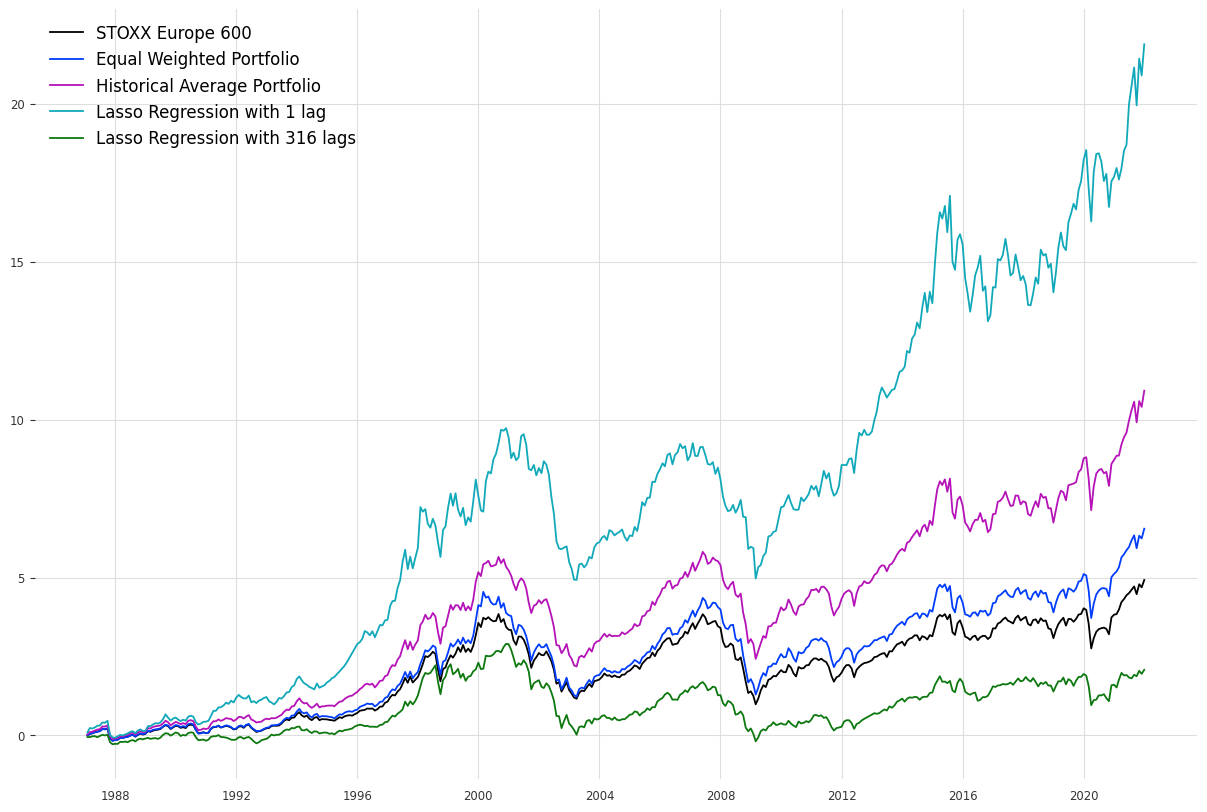

In [62]:
# plot the cumulative returns of the benchmark and the lasso regression portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['lasso_regression_1'], label='Lasso Regression with 1 lag')
plt.plot(portfolio_returns['lasso_regression_316'], label='Lasso Regression with 316 lags')
plt.legend(loc='upper left', fontsize=12)
plt.show();

In [ ]:
# show the last value of each portfolio and round it to 2 decimal places
print('Last value of the STOXX Europe 600: ' + str(np.round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2)) + '%')
print('Last value of the equal weighted portfolio: ' + str(np.round(portfolio_returns['equal_weighted'].iloc[-1], 2)) + '%')
print('Last value of the historical average portfolio: ' + str(np.round(portfolio_returns['historical_average'].iloc[-1], 2)) + '%')
print('Last value of the ridge regression portfolio with 1 lag: ' + str(np.round(portfolio_returns['ridge_regression_1'].iloc[-1], 12)) + '%')
print('Last value of the ridge regression portfolio with 316 lags: ' + str(np.round(portfolio_returns['ridge_regression_316'].iloc[-1], 5)) + '%')
# also for the linear regression portfolio
print('Last value of the linear regression portfolio: ' + str(np.round(portfolio_returns['linear_regression_1'].iloc[-1], 12)) + '%')
print('Last value of the linear regression portfolio: ' + str(np.round(portfolio_returns['linear_regression_316'].iloc[-1], 5)) + '%')
# also for lasso regression portfolio
print('Last value of the lasso regression portfolio with 1 lag: ' + str(np.round(portfolio_returns['lasso_regression_1'].iloc[-1], 2)) + '%')
print('Last value of the lasso regression portfolio with 316 lags: ' + str(np.round(portfolio_returns['lasso_regression_316'].iloc[-1], 2)) + '%')

Last value of the STOXX Europe 600: 4.92%
Last value of the equal weighted portfolio: 6.54%
Last value of the historical average portfolio: 10.91%
Last value of the ridge regression portfolio with 1 lag: 17.04989306887%
Last value of the ridge regression portfolio with 316 lags: 7.34663%
Last value of the linear regression portfolio: 17.049893068824%
Last value of the linear regression portfolio: 7.34673%
Last value of the lasso regression portfolio with 1 lag: 21.88%
Last value of the lasso regression portfolio with 316 lags: 2.08%


### Elastic Net

In [198]:
hyperparameter_elastic = {
    "lags": list(range(1,2)),
    'model': [
        sklearn.linear_model.ElasticNet(alpha=a) for a in np.arange(0, 1.1, 0.01)
    ]
}

In [199]:
elastic_net_tune = RegressionModel(
    lags= hyperparameter_elastic['lags'][0],
    model=sklearn.linear_model.ElasticNet(0)
)

In [200]:
tuning_elastic_net = elastic_net_tune.gridsearch(
    parameters= hyperparameter_elastic,
    series= train,
    val_series= test,
    start= 0.1,
   # metric= mape,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/110 [00:00<?, ?it/s]

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/darts/models/forecasting/regression_model.py:410: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.model.fit(training_samples, training_labels, **kwargs)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.522e+00, tolerance: 4.405e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fit

In [201]:
best_model, best_params = tuning_elastic_net[0], tuning_elastic_net[1]
# print the best model parameters
best_model.model_params

OrderedDict([('lags', 1),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model', ElasticNet(alpha=0.0)),
             ('multi_models', True),
             ('use_static_covariates', True)])

In [63]:
# I have tested the model with different lags, which have shown the best results for mape and mse
# elastic net regression model with 1 lag of STOXX Europe 600
elastic_model_1 = RegressionModel(lags=1, model=sklearn.linear_model.ElasticNet(alpha=0))
elastic_model_1.fit(train)
elastic_forecast_1 = elastic_model_1.predict(len(test))

# elastic net regression model with 316 lags of STOXX Europe 600
elastic_model_316 = RegressionModel(lags=316, model=sklearn.linear_model.ElasticNet(alpha=0))
elastic_model_316.fit(train)
elastic_forecast_316 = elastic_model_316.predict(len(test))

# elastic net regression model with 317 lags of STOXX Europe 600
elastic_model_317 = RegressionModel(lags=317, model=sklearn.linear_model.ElasticNet(alpha=0))
elastic_model_317.fit(train)
elastic_forecast_317 = elastic_model_317.predict(len(test))

# elastic net regression model with 335 lags of STOXX Europe 600
elastic_model_335 = RegressionModel(lags=335, model=sklearn.linear_model.ElasticNet(alpha=0))
elastic_model_335.fit(train)
elastic_forecast_335 = elastic_model_335.predict(len(test))

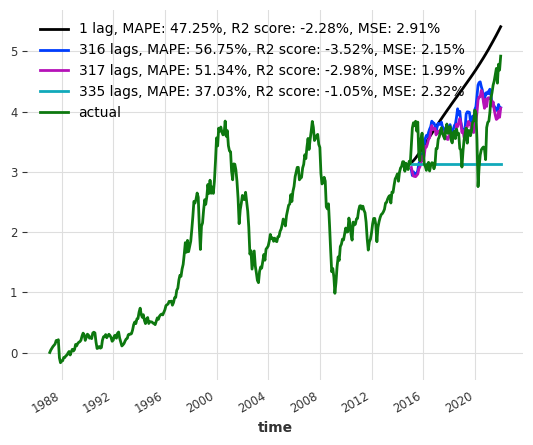

In [64]:
# plot the elastic net forecast with 1, 316, 317 and 335 lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
elastic_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, elastic_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, elastic_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, elastic_forecast_1), 2)) + '%')
elastic_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, elastic_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, elastic_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, elastic_forecast_316), 2)) + '%')
elastic_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, elastic_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, elastic_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, elastic_forecast_317), 2)) + '%')
elastic_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, elastic_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, elastic_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, elastic_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [65]:
# first elastic net regression model with 1 lag
hf1_elastic_net_regression = elastic_model_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# second elastic net regression model with 316 lags
hf2_elastic_net_regression = elastic_model_316.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# third elastic net regression model with 317 lags
hf3_elastic_net_regression = elastic_model_317.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# fourth elastic net regression model with 335 lags
hf4_elastic_net_regression = elastic_model_335.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

  0%|          | 0/169 [00:00<?, ?it/s]

`start` value `0.6` corresponding to timestamp `2008-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-08-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/102 [00:00<?, ?it/s]

`start` value `0.6` corresponding to timestamp `2008-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-09-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/101 [00:00<?, ?it/s]

`start` value `0.6` corresponding to timestamp `2008-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2015-03-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/83 [00:00<?, ?it/s]

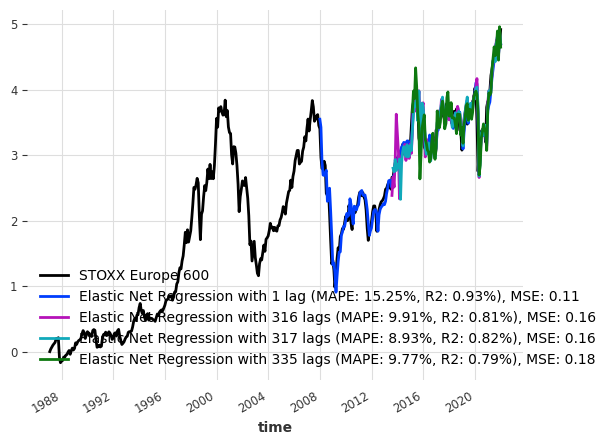

In [66]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_elastic_net_regression['STOXX Europe 600'].plot(label='Elastic Net Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_elastic_net_regression, cum_returns), r2_score(hf1_elastic_net_regression, cum_returns), mse(hf1_elastic_net_regression, cum_returns)))
hf2_elastic_net_regression['STOXX Europe 600'].plot(label='Elastic Net Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_elastic_net_regression, cum_returns), r2_score(hf2_elastic_net_regression, cum_returns), mse(hf2_elastic_net_regression, cum_returns)))
hf3_elastic_net_regression['STOXX Europe 600'].plot(label='Elastic Net Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf3_elastic_net_regression, cum_returns), r2_score(hf3_elastic_net_regression, cum_returns), mse(hf3_elastic_net_regression, cum_returns)))
hf4_elastic_net_regression['STOXX Europe 600'].plot(label='Elastic Net Regression with 335 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf4_elastic_net_regression, cum_returns), r2_score(hf4_elastic_net_regression, cum_returns), mse(hf4_elastic_net_regression, cum_returns)))

#### Portfolio

In [67]:
# change type of the elastic net forecasts to a pandas dataframe
elastic_forecast_1 = elastic_forecast_1.pd_dataframe()
elastic_forecast_316 = elastic_forecast_316.pd_dataframe()

In [68]:
# perform mean-variance optimization
mu_elastic_net_regression_1 = expected_returns.mean_historical_return(elastic_forecast_1)
S_elastic_net_regression_1 = risk_models.sample_cov(elastic_forecast_1)

mu_elastic_net_regression_316 = expected_returns.mean_historical_return(elastic_forecast_316)
S_elastic_net_regression_316 = risk_models.sample_cov(elastic_forecast_316)

In [69]:
# optimize for maximal Sharpe ratio
ef_elastic_net_regression_1 = EfficientFrontier(mu_elastic_net_regression_1, S_elastic_net_regression_1)
weights_enr_1 = ef_elastic_net_regression_1.max_sharpe()

ef_elastic_net_regression_316 = EfficientFrontier(mu_elastic_net_regression_316, S_elastic_net_regression_316)
weights_enr_316 = ef_elastic_net_regression_316.max_sharpe()

In [ ]:
# print the weights in a table and round them to 4 decimals
print('Weights for Elastic Net regression with 1 lag: ' + str(np.round(pd.Series(weights_enr_1), 3)))
print('Weights for Elastic Net regression with 316 lags: ' + str(np.round(pd.Series(weights_enr_316), 3)))

Weights for Elastic Net regression with 1 lag: STOXX Europe 600               0.000
STOXX Europe Banks             0.000
STOXX Europe Financials        0.000
STOXX Europe Auto & Parts      0.000
STOXX Europe Insurance         0.000
STOXX Europe Technology        0.023
STOXX Europe Utilities         0.000
STOXX Europe Chemicals         0.000
STOXX Europe Basic Resource    0.108
STOXX Europe Con & Mat         0.000
STOXX Europe Health Care       0.869
STOXX Europe Inds Gds & Svs    0.000
STOXX Europe Media             0.000
STOXX Europe Telecoms          0.000
dtype: float64
Weights for Elastic Net regression with 316 lags: STOXX Europe 600               0.000
STOXX Europe Banks             0.000
STOXX Europe Financials        0.000
STOXX Europe Auto & Parts      0.111
STOXX Europe Insurance         0.886
STOXX Europe Technology        0.000
STOXX Europe Utilities         0.000
STOXX Europe Chemicals         0.000
STOXX Europe Basic Resource    0.000
STOXX Europe Con & Mat         0.000


In [70]:
# compute the returns of elastic net regression portfolio
enr_returns_1 = (cum_returns_portfolio * weights_enr_1).sum(axis=1)
enr_returns_316 = (cum_returns_portfolio * weights_enr_316).sum(axis=1)

portfolio_returns['Elastic_Net_1'] = enr_returns_1
portfolio_returns['Elastic_Net_316'] = enr_returns_316

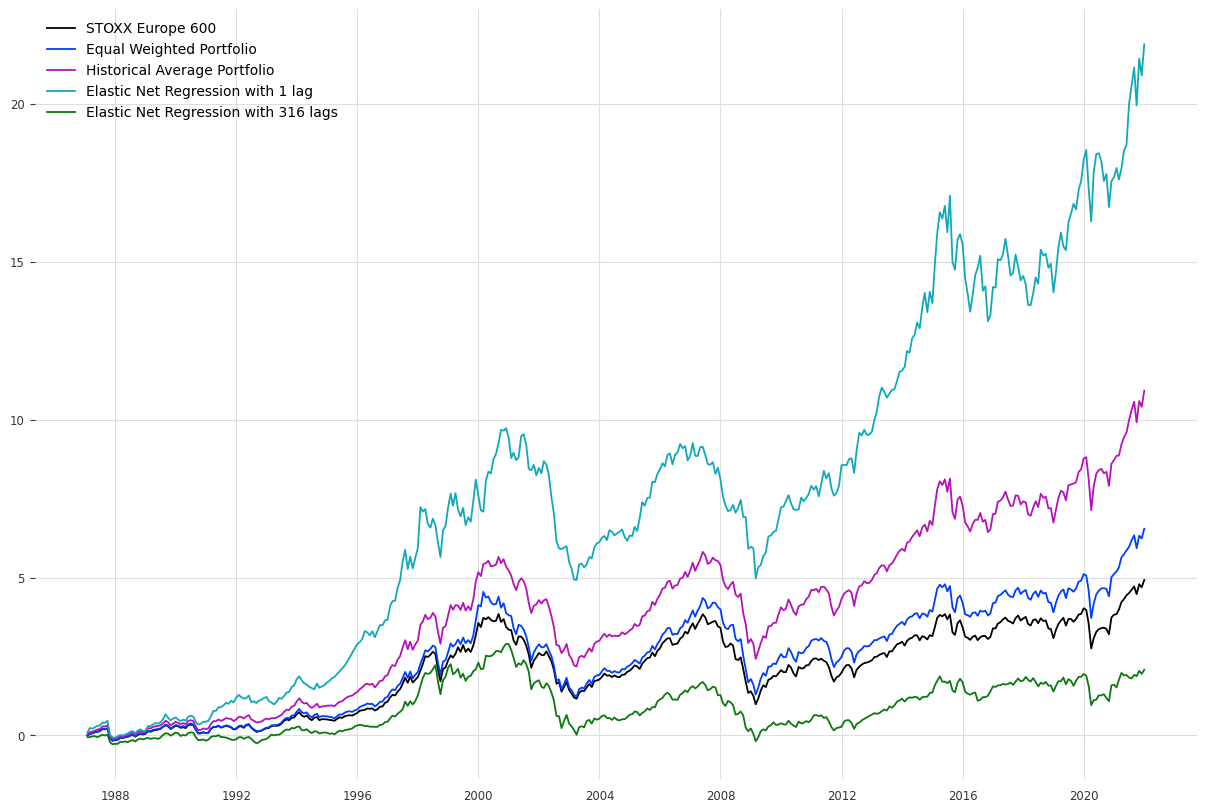

In [71]:
# plot the cumulative returns of the benchmark and the elastic net regression portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['Elastic_Net_1'], label='Elastic Net Regression with 1 lag')
plt.plot(portfolio_returns['Elastic_Net_316'], label='Elastic Net Regression with 316 lags')
plt.legend(loc='upper left')
plt.show();

In [ ]:
# show the last value of each portfolio and round it to 2 decimal places
print('Last value of the STOXX Europe 600: ' + str(np.round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2)) + '%')
print('Last value of the equal weighted portfolio: ' + str(np.round(portfolio_returns['equal_weighted'].iloc[-1], 2)) + '%')
print('Last value of the historical average portfolio: ' + str(np.round(portfolio_returns['historical_average'].iloc[-1], 2)) + '%')
print('Last value of the ridge regression portfolio with 1 lag: ' + str(np.round(portfolio_returns['ridge_regression_1'].iloc[-1], 12)) + '%')
print('Last value of the ridge regression portfolio with 316 lags: ' + str(np.round(portfolio_returns['ridge_regression_316'].iloc[-1], 5)) + '%')
# also for the linear regression portfolio
print('Last value of the linear regression portfolio: ' + str(np.round(portfolio_returns['linear_regression_1'].iloc[-1], 12)) + '%')
print('Last value of the linear regression portfolio: ' + str(np.round(portfolio_returns['linear_regression_316'].iloc[-1], 5)) + '%')
# also for the lasso regression portfolio
print('Last value of the lasso regression portfolio: ' + str(np.round(portfolio_returns['lasso_regression_1'].iloc[-1], 2)) + '%')
print('Last value of the lasso regression portfolio: ' + str(np.round(portfolio_returns['lasso_regression_316'].iloc[-1], 2)) + '%')
# also for the elastic net regression portfolio
print('Last value of the elastic net regression portfolio with 1 lag: ' + str(np.round(portfolio_returns['Elastic_Net_1'].iloc[-1], 2)) + '%')
print('Last value of the elastic net regression portfolio with 316 lags: ' + str(np.round(portfolio_returns['Elastic_Net_316'].iloc[-1], 2)) + '%')

Last value of the STOXX Europe 600: 4.92%
Last value of the equal weighted portfolio: 6.54%
Last value of the historical average portfolio: 10.91%
Last value of the ridge regression portfolio with 1 lag: 17.04989306887%
Last value of the ridge regression portfolio with 316 lags: 7.34663%
Last value of the linear regression portfolio: 17.049893068824%
Last value of the linear regression portfolio: 7.34673%
Last value of the lasso regression portfolio: 21.88%
Last value of the lasso regression portfolio: 2.08%
Last value of the elastic net regression portfolio with 1 lag: 21.88%
Last value of the elastic net regression portfolio with 316 lags: 2.08%


### Bridge Regression

In [30]:
hyperparameter_bridge = {
    "lags": list(range(1,336, 10)),
    'model': [
        sklearn.linear_model.LassoLarsCV(cv=c, n_jobs=-1) 
        for c in np.arange(2, 13, 1)
    ]
}

In [31]:
bridge_regression_tune = RegressionModel(
    lags= hyperparameter_bridge['lags'][0],
    model=sklearn.linear_model.LassoLarsCV(cv=0, n_jobs=-1)
)

In [32]:
tuning_bridge = bridge_regression_tune.gridsearch(
    parameters= hyperparameter_bridge,
    series= train,
    val_series= test,
    start= 0.1,
    #metric= mape,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/374 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
best_model, best_params = tuning_bridge[0], tuning_bridge[1]
# print the best model parameters
best_model.model_params

In [20]:
# I have tested the model with different lags, which have shown the best results for mape and mse
# bridge regression model with 1 lag of STOXX Europe 600
bridge_regression_1 = RegressionModel(lags= 1, model=sklearn.linear_model.LassoLarsCV(cv=2, n_jobs=-1))
bridge_regression_1.fit(train)
bridge_forecast_1 = bridge_regression_1.predict(len(test))

# bridge regression model with 316 lags of STOXX Europe 600
bridge_regression_316 = RegressionModel(lags= 316, model=sklearn.linear_model.LassoLarsCV(cv=2, n_jobs=-1))
bridge_regression_316.fit(train)
bridge_forecast_316 = bridge_regression_316.predict(len(test))

# bridge regression model with 317 lags of STOXX Europe 600
bridge_regression_317 = RegressionModel(lags= 317, model=sklearn.linear_model.LassoLarsCV(cv=2, n_jobs=-1))
bridge_regression_317.fit(train)
bridge_forecast_317 = bridge_regression_317.predict(len(test))

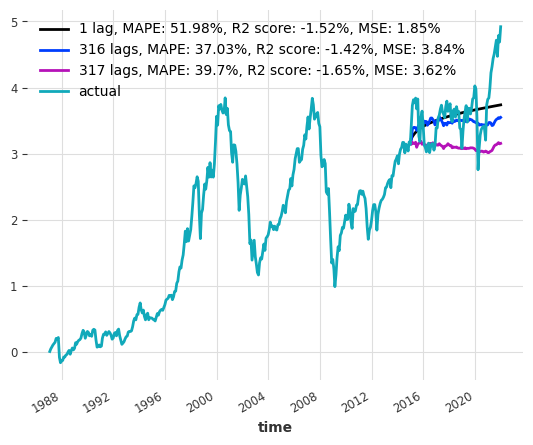

In [21]:
# plot the bridge forecast with 1, 316, 317  lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
bridge_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, bridge_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, bridge_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, bridge_forecast_1), 2)) + '%')
bridge_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, bridge_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, bridge_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, bridge_forecast_316), 2)) + '%')
bridge_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, bridge_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, bridge_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, bridge_forecast_317), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [24]:
bridge_regression_316

RegressionModel(lags=316, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, add_encoders=None, model=LassoLarsCV(cv=2, n_jobs=-1), multi_models=True, use_static_covariates=True)

In [26]:
# first bridge regression model with 1 lag
hf1_bridge_regression = bridge_regression_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)
# second bridge regression model with 316 lags
#hf2_bridge_regression = bridge_regression_316.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)
# third bridge regression model with 317 lags
#hf3_bridge_regression = bridge_regression_317.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

  0%|          | 0/169 [00:00<?, ?it/s]

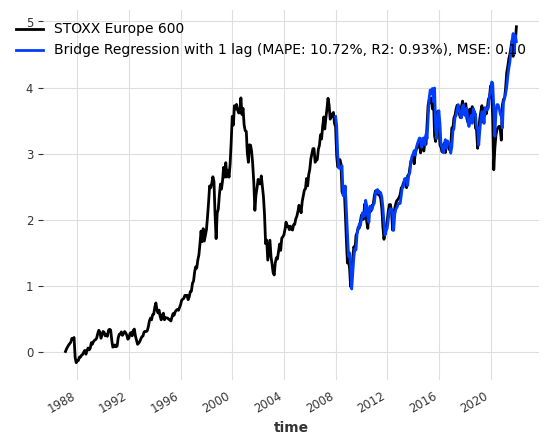

In [27]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_bridge_regression['STOXX Europe 600'].plot(label='Bridge Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_bridge_regression, cum_returns), r2_score(hf1_bridge_regression, cum_returns), mse(hf1_bridge_regression, cum_returns)))
#hf2_bridge_regression['STOXX Europe 600'].plot(label='Bridge Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_bridge_regression, cum_returns), r2_score(hf2_bridge_regression, cum_returns), mse(hf2_bridge_regression, cum_returns)))
#hf3_bridge_regression['STOXX Europe 600'].plot(label='Bridge Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf3_bridge_regression, cum_returns), r2_score(hf3_bridge_regression, cum_returns), mse(hf3_bridge_regression, cum_returns)))
#hf4_bridge_regression['STOXX Europe 600'].plot(label='Bridge Regression with 335 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf4_bridge_regression, cum_returns), r2_score(hf4_bridge_regression, cum_returns), mse(hf4_bridge_regression, cum_returns)))

#### Portfolio

In [28]:
# change the type of the bridge forecast to pandas dataframe
bridge_forecast_1 = bridge_forecast_1.pd_dataframe()

In [29]:
# perform mean-variance optimization
mu_bridge_regression_1 = expected_returns.mean_historical_return(bridge_forecast_1)
S_bridge_regression_1 = risk_models.sample_cov(bridge_forecast_1)

In [30]:
# optimize for maximal Sharpe ratio
ef_bridge_regression_1 = EfficientFrontier(mu_bridge_regression_1, S_bridge_regression_1)
weights_br_1 = ef_bridge_regression_1.max_sharpe()

In [31]:
# print the weights in a table and round them to 4 decimals
print('Weights for Bridge regression with 1 lag: ' + str(np.round(pd.Series(weights_br_1), 3)))

Weights for Bridge regression with 1 lag: STOXX Europe 600               0.000
STOXX Europe Banks             0.000
STOXX Europe Financials        0.000
STOXX Europe Auto & Parts      0.000
STOXX Europe Insurance         0.000
STOXX Europe Technology        0.000
STOXX Europe Utilities         0.000
STOXX Europe Chemicals         0.000
STOXX Europe Basic Resource    0.000
STOXX Europe Con & Mat         0.018
STOXX Europe Health Care       0.982
STOXX Europe Inds Gds & Svs    0.000
STOXX Europe Media             0.000
STOXX Europe Telecoms          0.000
dtype: float64


In [32]:
# compute the returns of bridge regression portfolio
br_returns_1 = (cum_returns_portfolio * weights_br_1).sum(axis=1)

portfolio_returns['bridge_regression_1'] = br_returns_1

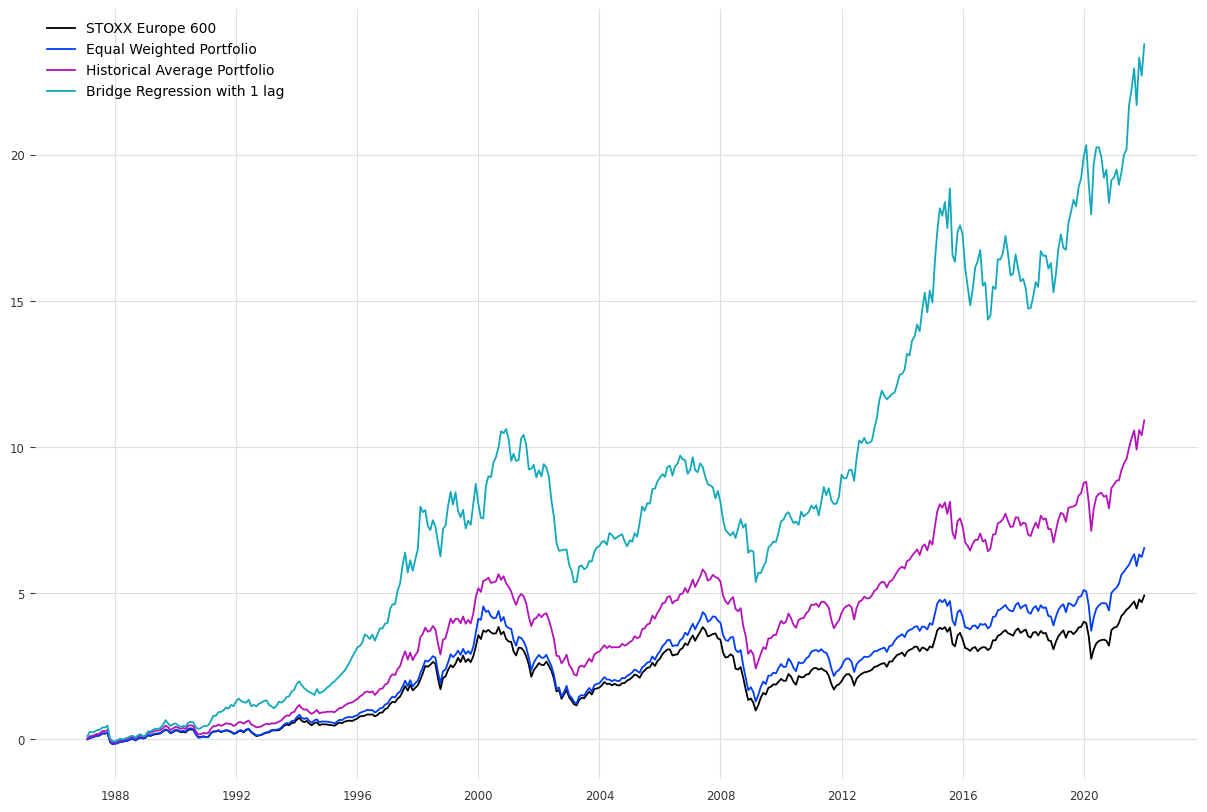

In [33]:
# plot the cumulative returns of the benchmark and the bridge regression portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['bridge_regression_1'], label='Bridge Regression with 1 lag')
plt.legend(loc='upper left')
plt.show();

# Outcome Shrinkage Portfolio Building

First generate a graph showing all models compared to their benchmarks & then create a table showing the numerical results.

In [72]:
portfolio_returns.tail()

component,equal_weighted,historical_average,bridge_regression_1,linear_regression_1,linear_regression_316,ridge_regression_1,ridge_regression_316,lasso_regression_1,lasso_regression_316,Elastic_Net_1,Elastic_Net_316
time,,,,,,,,,,,
2021-09-01,6.334322,10.565259,22.959692,16.437174,7.241788,23.264545,7.241712,21.147879,1.920520,21.147879,1.920520
2021-10-01,5.926514,9.912039,21.698781,15.535828,6.504470,21.991305,6.504401,19.946396,1.875364,19.946396,1.875364
2021-11-01,6.322933,10.583310,23.323187,16.720072,6.839192,23.637809,6.839120,21.427089,2.045217,21.427089,2.045217
2021-12-01,6.237121,10.402550,22.707336,16.281803,6.914258,23.011935,6.914185,20.892168,1.949463,20.892168,1.949463
2022-01-01,6.544394,10.913366,23.780296,17.049893,7.346731,24.096923,7.346652,21.880713,2.078423,21.880713,2.078423


In [1]:
# plot all the cumulative returns
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], color= 'black', label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], color= 'red', label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], color= 'green', label='Historical Average Portfolio')
# plot linear regression with 1 lag
plt.plot(portfolio_returns['linear_regression_1'], color= 'blue', label='Linear Regression with 1 lag')
# plot ridge regression with 1 lag
plt.plot(portfolio_returns['ridge_regression_1'], color= 'orange', label='Ridge Regression with 1 lag')
# plot lasso regression with 1 lag
plt.plot(portfolio_returns['lasso_regression_1'], color= 'purple', label='Lasso Regression with 1 lag')
# plot bridge regression with 1 lag
plt.plot(portfolio_returns['bridge_regression_1'], color= 'brown', label='Bridge Regression with 1 lag')
# plot elastic net regression with 1 lag
plt.plot(portfolio_returns['Elastic_Net_1'], color= 'pink', label='Elastic Net Regression with 1 lag')
plt.legend(loc='upper left')
# set the title of the plot
plt.title('Cumulative Returns of the Benchmark and the Dimensionality Reduction Portfolios')
# set the x-axis label
plt.xlabel('Date')
# set the y-axis label
plt.ylabel('Cumulative Returns')
# show the plot
plt.show();

NameError: name 'plt' is not defined

In [74]:
import tabulate

In [77]:
import pandas as pd

# Create a dictionary with the data
data = {
    'Portfolio': ['STOXX Europe 600', 'Equal Weighted Portfolio', 'Historical Average Portfolio', 'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net Regression', 'Bridge Regression'],
    '1 Lag': [cum_returns_portfolio['STOXX Europe 600'].tail(1).values[0], 
              portfolio_returns['equal_weighted'].tail(1).values[0], 
              portfolio_returns['historical_average'].tail(1).values[0],
              portfolio_returns['linear_regression_1'].tail(1).values[0],
                portfolio_returns['ridge_regression_1'].tail(1).values[0],
                portfolio_returns['lasso_regression_1'].tail(1).values[0],
                portfolio_returns['Elastic_Net_1'].tail(1).values[0],
                portfolio_returns['bridge_regression_1'].tail(1).values[0]],
    '316 Lags': [cum_returns_portfolio['STOXX Europe 600'].tail(1).values[0], 
                 portfolio_returns['equal_weighted'].tail(1).values[0], 
                 portfolio_returns['historical_average'].tail(1).values[0],
                   portfolio_returns['linear_regression_316'].tail(1).values[0],
                   portfolio_returns['ridge_regression_316'].tail(1).values[0],
                  portfolio_returns['lasso_regression_316'].tail(1).values[0],
                  portfolio_returns['Elastic_Net_316'].tail(1).values[0],
                  None]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Divide the values by 100 to get the percentage
df[['1 Lag', '316 Lags']] = df[['1 Lag', '316 Lags']].div(100)

# Set the index of the DataFrame to be the Portfolio column
df.set_index('Portfolio', inplace=True)

# Format the DataFrame to display the values as percentages
df.style.format("{:.3%}", subset=['1 Lag', '316 Lags'])


,1 Lag,316 Lags
Portfolio,,
STOXX Europe 600,4.921%,4.921%
Equal Weighted Portfolio,6.544%,6.544%
Historical Average Portfolio,10.913%,10.913%
Linear Regression,17.050%,7.347%
Ridge Regression,24.097%,7.347%
Lasso Regression,21.881%,2.078%
Elastic Net Regression,21.881%,2.078%
Bridge Regression,23.780%,nan%


In [78]:
# print this customized table to latex including the percentage sign and multiply the values by 100
print(df.to_latex(float_format="%.3f", formatters={"1 Lag": "{:.2%}".format, "316 Lags": "{:.2%}".format}))

\begin{tabular}{lrr}
\toprule
{} &  1 Lag & 316 Lags \\
Portfolio                    &        &          \\
\midrule
STOXX Europe 600             &  4.92\% &    4.92\% \\
Equal Weighted Portfolio     &  6.54\% &    6.54\% \\
Historical Average Portfolio & 10.91\% &   10.91\% \\
Linear Regression            & 17.05\% &    7.35\% \\
Ridge Regression             & 24.10\% &    7.35\% \\
Lasso Regression             & 21.88\% &    2.08\% \\
Elastic Net Regression       & 21.88\% &    2.08\% \\
Bridge Regression            & 23.78\% &      NaN \\
\bottomrule
\end{tabular}

